In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the CSV file
df = pd.read_csv("Marital-satisfaction_Data.csv")

In [3]:
# Quick inspection
df.columns
df.head()

,Country,Gender,Age,Marriage_years,children,brought_up_children,Education,Material_status,Religion,Religiosity,...,KMSS2,KMSS3,Scale1,Scale2,Scale3,Scale4,Scale5,Scale6,Scale7,Scale8
0,Brazil,1,21.0,2.0,0,0,5,0,1.0,4,...,7,7,1,1,1,1,1,1,1,1
1,Brazil,1,29.0,3.0,1,0,5,3,1.0,6,...,6,6,2,1,1,1,1,1,1,1
2,Brazil,1,30.0,7.0,0,0,5,3,1.0,4,...,7,7,2,1,2,1,1,1,1,1
3,Brazil,1,30.0,7.0,1,1,5,3,1.0,6,...,6,6,3,1,1,2,1,1,1,1
4,Brazil,1,28.0,9.0,0,0,4,2,1.0,5,...,6,7,3,2,3,2,1,1,1,1


Q1: Do individuals with high marital satisfaction tend to report both frequent communication and mutual decision-making?
We’ll assume:

Love1, Love2, Love3, Love4, Love5 represent relationship quality, including communication and shared decision-making

Material_status is Marital Satisfaction (rename for clarity)

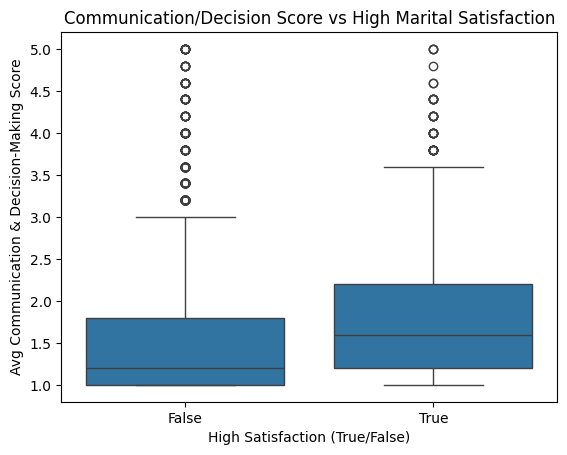

In [5]:
# Rename for clarity
df = df.rename(columns={"Material_status": "Marital_satisfaction"})

# Create a new column: average communication & decision-making score
df["Communication_Decision_Score"] = df[["Love1", "Love2", "Love3", "Love4", "Love5"]].mean(axis=1)

# Define "High satisfaction" as Marital_satisfaction >= 4 (scale is 0–5)
df["High_Satisfaction"] = df["Marital_satisfaction"] >= 4

# Boxplot of communication score vs satisfaction level
sns.boxplot(x="High_Satisfaction", y="Communication_Decision_Score", data=df)
plt.title("Communication/Decision Score vs High Marital Satisfaction")
plt.xlabel("High Satisfaction (True/False)")
plt.ylabel("Avg Communication & Decision-Making Score")
plt.show()

Q2: Is low marital satisfaction more prevalent among individuals with both low economic status and low education?

In [8]:
# Fill missing Pension with 0 (assume no pension)
df["Pension"] = df["Pension"].fillna(0)

# Define conditions
df["Low_Education"] = df["Education"] <= 2
df["Low_Econ"] = df["Pension"] == 0
df["Low_Satisfaction"] = df["Marital_satisfaction"] <= 2

# Filter: those with both low econ and low education
subset = df[(df["Low_Education"]) & (df["Low_Econ"])]

# Proportion with low satisfaction
low_sat_rate = subset["Low_Satisfaction"].mean()
print(f"Low satisfaction rate among low-education, low-econ individuals: {low_sat_rate:.2f}")

Low satisfaction rate among low-education, low-econ individuals: nan


Q3: Are childless couples with short marriage durations more likely to report dissatisfaction?
Assume:

No children: children == 0

Short marriage: Marriage_years < 5

Low satisfaction: ≤ 2

In [9]:
df["Childless"] = df["children"] == 0
df["Short_Marriage"] = df["Marriage_years"] < 5
df["Low_Satisfaction"] = df["Marital_satisfaction"] <= 2

subset = df[(df["Childless"]) & (df["Short_Marriage"])]
low_sat_rate = subset["Low_Satisfaction"].mean()
print(f"Dissatisfaction rate (childless & short marriage): {low_sat_rate:.2f}")

Dissatisfaction rate (childless & short marriage): 0.43


Q4: Does higher satisfaction associate with shared religious beliefs, regardless of income or education?
Assume:

Shared beliefs = high Religiosity (≥ 6)

High satisfaction = Marital_satisfaction ≥ 4

In [10]:
df["Shared_Religion"] = df["Religiosity"] >= 6
df["High_Satisfaction"] = df["Marital_satisfaction"] >= 4

# Group by Shared Religion
grouped = df.groupby("Shared_Religion")["High_Satisfaction"].mean()
print("High satisfaction rate by shared religion:")
print(grouped)

High satisfaction rate by shared religion:
Shared_Religion
False    0.099911
True     0.081659
Name: High_Satisfaction, dtype: float64
